In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10

(x_train, _), (x_test, _) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

input_shape = (32, 32, 3)

def add_noise_and_blur(images):
    noisy_images = []
    for img in images:
        noisy_img = img + 0.1 * np.random.normal(0, 1, img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        blurred_img = cv2.GaussianBlur(noisy_img, (5,5), 0)
        noisy_images.append(blurred_img)
    return np.array(noisy_images)

x_train_noisy = add_noise_and_blur(x_train)
x_test_noisy = add_noise_and_blur(x_test)

def build_autoencoder():
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    return model

autoencoder = build_autoencoder()
autoencoder.compile(optimizer=Adam(), loss='mse')

autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=64, validation_data=(x_test_noisy, x_test))

def compute_psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    return 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else 100  # PSNR formula

predictions = autoencoder.predict(x_test_noisy)



Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 169ms/step - loss: 0.0159 - val_loss: 0.0055
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 165ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 124s 159ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 161ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 125s 159ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 159ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 164ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 163ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 163ms/step - loss: 0.0035 - val_loss: 0.0035
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


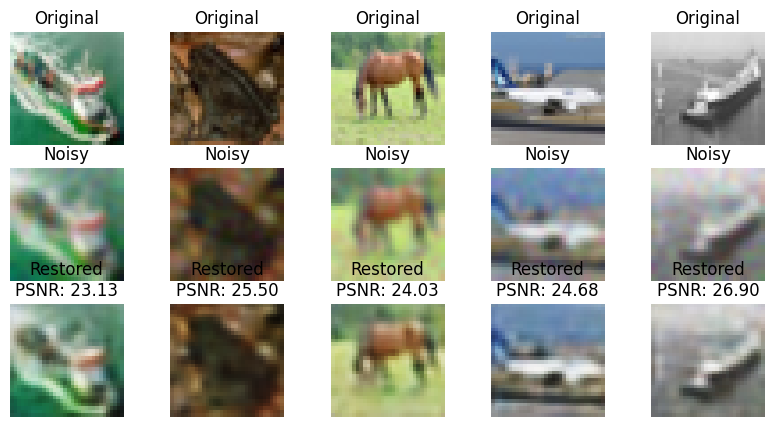

In [4]:
example_indices = [15, 30, 60, 90, 120]  # New indices for demonstration

plt.figure(figsize=(10, 5))

for i, idx in enumerate(example_indices):
    plt.subplot(3, len(example_indices), i + 1)
    plt.imshow(x_test[idx])
    plt.axis('off')
    plt.title("Original")

    plt.subplot(3, len(example_indices), i + 1 + len(example_indices))
    plt.imshow(x_test_noisy[idx])
    plt.axis('off')
    plt.title("Noisy")

    plt.subplot(3, len(example_indices), i + 1 + 2 * len(example_indices))
    plt.imshow(predictions[idx])
    plt.axis('off')
    plt.title(f"Restored\nPSNR: {compute_psnr(x_test[idx], predictions[idx]):.2f}")

plt.show()


In [3]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar100

In [5]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

print(f"Train Data: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test Data: {x_test.shape}, Labels: {y_test.shape}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Train Data: (50000, 32, 32, 3), Labels: (50000, 100)
Test Data: (10000, 32, 32, 3), Labels: (10000, 100)


In [6]:
def build_alexnet(input_shape, num_classes):
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),  # Define Input Layer

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),  # Avoid reducing feature map to 0

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

alexnet = build_alexnet((32, 32, 3), 100)
alexnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
alexnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,618,980 (9.99 MB)

 Trainable params: 2,618,980 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
base_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

for layer in base_vgg16.layers:
    layer.trainable = False

vgg16 = Sequential([
    base_vgg16,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

vgg16.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,028,644 (57.33 MB)

 Trainable params: 313,956 (1.20 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
epochs = 10
batch_size = 64

start_time = time.time()
alexnet_history = alexnet.fit(x_train, y_train, validation_data=(x_test, y_test),
                              epochs=epochs, batch_size=batch_size)
alexnet_time = time.time() - start_time
print(f"AlexNet Training Time: {alexnet_time:.2f} sec")

start_time = time.time()
vgg16_history = vgg16.fit(x_train, y_train, validation_data=(x_test, y_test),
                           epochs=epochs, batch_size=batch_size)
vgg16_time = time.time() - start_time
print(f"VGG16 Training Time: {vgg16_time:.2f} sec")

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 533s 678ms/step - accuracy: 0.0211 - loss: 4.4563 - val_accuracy: 0.0764 - val_loss: 3.9344
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 563s 680ms/step - accuracy: 0.0802 - loss: 3.9262 - val_accuracy: 0.1616 - val_loss: 3.5598
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 562s 681ms/step - accuracy: 0.1422 - loss: 3.5877 - val_accuracy: 0.2057 - val_loss: 3.2664
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 561s 679ms/step - accuracy: 0.1866 - loss: 3.3248 - val_accuracy: 0.2500 - val_loss: 3.0547
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 563s 681ms/step - accuracy: 0.2229 - loss: 3.1302 - val_accuracy: 0.2669 - val_loss: 2.9700
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 561s 679ms/step - accuracy: 0.2546 - loss: 2.9730 - val_accuracy: 0.2833 - val_loss: 2.8830
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 562s 679ms/step - accuracy: 0.2825 - loss: 2.8364 - val_accuracy: 0.3032 - val_loss: 2.7711
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 560s 676ms/step - accuracy: 0.2933 -

In [9]:
alexnet_eval = alexnet.evaluate(x_test, y_test, verbose=0)
vgg16_eval = vgg16.evaluate(x_test, y_test, verbose=0)

print(f"AlexNet Test Accuracy: {alexnet_eval[1]:.4f}, Loss: {alexnet_eval[0]:.4f}")
print(f"VGG16 Test Accuracy: {vgg16_eval[1]:.4f}, Loss: {vgg16_eval[0]:.4f}")

AlexNet Test Accuracy: 0.3420, Loss: 2.6069
VGG16 Test Accuracy: 0.3635, Loss: 2.5073


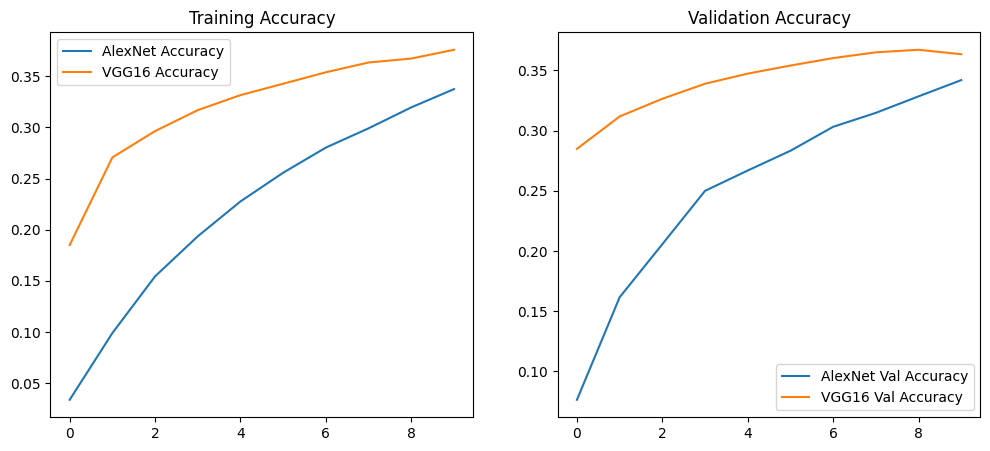

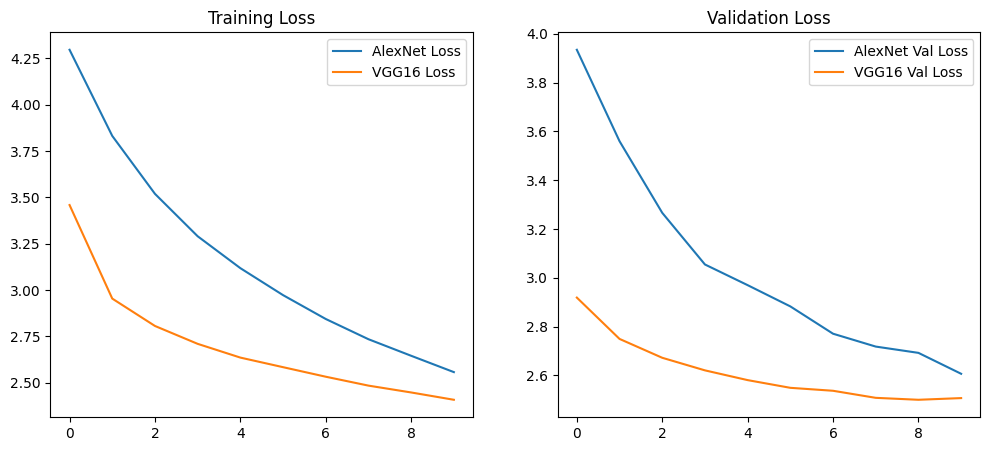

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alexnet_history.history['accuracy'], label="AlexNet Accuracy")
plt.plot(vgg16_history.history['accuracy'], label="VGG16 Accuracy")
plt.legend()
plt.title("Training Accuracy")

plt.subplot(1, 2, 2)
plt.plot(alexnet_history.history['val_accuracy'], label="AlexNet Val Accuracy")
plt.plot(vgg16_history.history['val_accuracy'], label="VGG16 Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alexnet_history.history['loss'], label="AlexNet Loss")
plt.plot(vgg16_history.history['loss'], label="VGG16 Loss")
plt.legend()
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(alexnet_history.history['val_loss'], label="AlexNet Val Loss")
plt.plot(vgg16_history.history['val_loss'], label="VGG16 Val Loss")
plt.legend()
plt.title("Validation Loss")

plt.show()

In [11]:

print(f"Model\t\t| Test Accuracy\t| Test Loss\t| Training Time")
print("-" * 50)
print(f"AlexNet\t\t| {alexnet_eval[1]:.4f}\t\t| {alexnet_eval[0]:.4f}\t\t| {alexnet_time:.2f} sec")
print(f"VGG16\t\t| {vgg16_eval[1]:.4f}\t\t| {vgg16_eval[0]:.4f}\t\t| {vgg16_time:.2f} sec")

Model		| Test Accuracy	| Test Loss	| Training Time
--------------------------------------------------
AlexNet		| 0.3420		| 2.6069		| 5557.94 sec
VGG16		| 0.3635		| 2.5073		| 4905.50 sec
